In [1]:
import numpy as np
import seaborn as sns
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
number_of_stocks = 100
risk_parameter = 1/2.

In [3]:
def find_robust_markowitz_weights(nominal_returns, nominal_covariance_matrix, returns_radii, kappa, risk_parameter):
    # Set ut the problem
    volatilities = np.sqrt(np.diag(nominal_covariance_matrix))
    n = len(nominal_returns)
    weights = cp.Variable(n)
    objective = cp.matmul(nominal_returns, weights)\
        - (cp.matmul(cp.abs(weights), returns_radii)) \
        - risk_parameter * cp.quad_form(weights, nominal_covariance_matrix)\
        - risk_parameter * kappa * cp.square(cp.matmul(volatilities, weights))
    
    constraints = [cp.sum(weights) == 1] # allow shorting
    prob = cp.Problem(cp.Maximize(objective), constraints)

    # Solving the problem
    prob.solve()
    return weights.value

In [4]:
def get_bootstrapped_returns_and_covariances(return_samples, number_of_bootstrap_samples):
    returns = []
    covariances = []
    for _ in range(number_of_bootstrap_samples):
        indices = np.random.choice(range(len(return_samples)), size = len(return_samples), replace=True)
        bootstrap_returns = return_samples[:, indices]
        returns.append(bootstrap_returns.mean(axis=1))
        covariances.append(np.cov(bootstrap_returns))
    return returns, covariances

In [5]:
def get_uncertainty_set_parameters(bootstrap_returns, bootstrap_covariances, estimated_covariance): 
    np_bootstrap_returns = np.array(bootstrap_returns)
    np_bootstrap_covariances = np.array(bootstrap_covariances)

    returns_max = np_bootstrap_returns.max(axis=0)
    returns_min = np_bootstrap_returns.min(axis=0)
    nominal_returns = 1/2. * (returns_max + returns_min)
    returns_radii = 1/2. *(returns_max - nominal_returns)

    std_deviations = np.sqrt(np.diag(estimated_covariance))
    matrix_with_std_deviation_j = np.tile(std_deviations, (std_deviations.shape[0], 1))
    matrix_with_std_deviation_i = matrix_with_std_deviation_j.T
    inverse_sigma_ii_jj = 1 / (matrix_with_std_deviation_i * matrix_with_std_deviation_j)
    kappas = np.abs((np_bootstrap_covariances - estimated_covariance) * inverse_sigma_ii_jj).max(axis=0)
    kappa = kappas.max()

    return nominal_returns, returns_radii, estimated_covariance, kappa


In [6]:

def find_robust_markowitz_weights_with_given_number_of_observations(number_of_daily_observations, number_of_bootstrap_samples):
    return_samples = .1 * np.random.randn(number_of_stocks, number_of_daily_observations) # .1 is so that all have sigma = .1
    # estimated_returns = all_returns.mean(axis=1)
    estimated_covariance = np.cov(return_samples)

    bootstrap_returns, bootstrap_covariances = get_bootstrapped_returns_and_covariances(return_samples, number_of_bootstrap_samples)
    
    nominal_returns, returns_radii, estimated_covariance, kappa = get_uncertainty_set_parameters(bootstrap_returns, bootstrap_covariances, estimated_covariance)
    
    return find_robust_markowitz_weights(nominal_returns, estimated_covariance, returns_radii, kappa, risk_parameter)

Text(0, 0.5, 'Portolio Allocation')

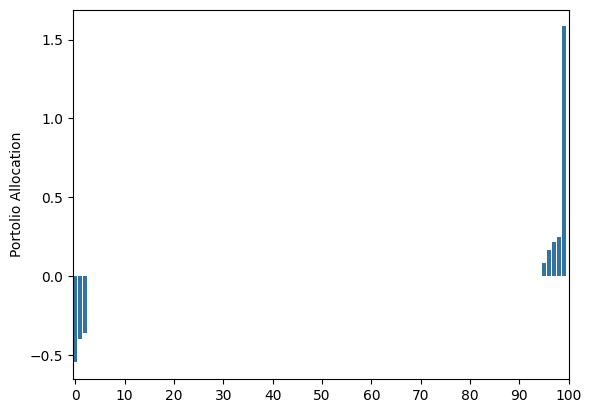

In [9]:
robust_markowitz_portfolio_1_years = find_robust_markowitz_weights_with_given_number_of_observations(252 * 1, 5000)
ax = sns.barplot(sorted(robust_markowitz_portfolio_1_years))
ax.set_xticks(range(0, len(ax.get_xticklabels()) + 1, len(ax.get_xticklabels()) // 10 ))
ax.set_xticklabels(range(0, 101, 10));
plt.ylabel("Portolio Allocation")

Text(0, 0.5, 'Portolio Allocation')

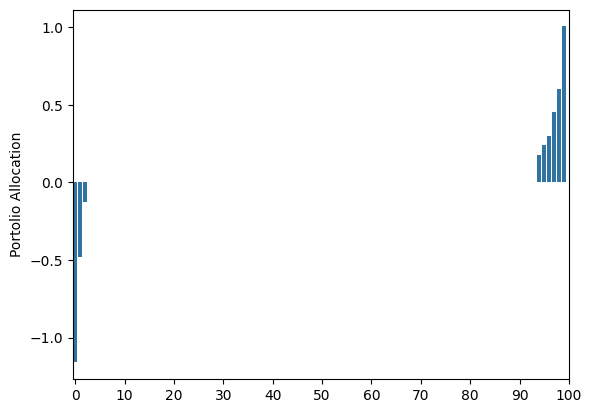

In [31]:
robust_markowitz_portfolio_10000_years = find_robust_markowitz_weights_with_given_number_of_observations(252 * 10000, 5000)
ax = sns.barplot(sorted(robust_markowitz_portfolio_10000_years))
ax.set_xticks(range(0, len(ax.get_xticklabels()) + 1, len(ax.get_xticklabels()) // 10 ))
ax.set_xticklabels(range(0, 101, 10));
plt.ylabel("Portolio Allocation")

In [32]:
robust_markowitz_portfolio_10000_years = find_robust_markowitz_weights_with_given_number_of_observations(252 * 100000, 100)
ax = sns.barplot(sorted(robust_markowitz_portfolio_10000_years))
ax.set_xticks(range(0, len(ax.get_xticklabels()) + 1, len(ax.get_xticklabels()) // 10 ))
ax.set_xticklabels(range(0, 101, 10));
plt.ylabel("Portolio Allocation")

: 